In [1]:
!pip install pafy youtube-dl moviepy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install moviepy
!pip3 install imageio==2.4.1
!pip install --upgrade imageio-ffmpeg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import os
import cv2
import math
import pafy
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from moviepy.editor import *
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
 
from sklearn.model_selection import train_test_split
 
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [4]:
seed_constant = 23
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [5]:
!wget -nc --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar
!unrar x UCF50.rar -inul -y


File ‘UCF50.rar’ already there; not retrieving.



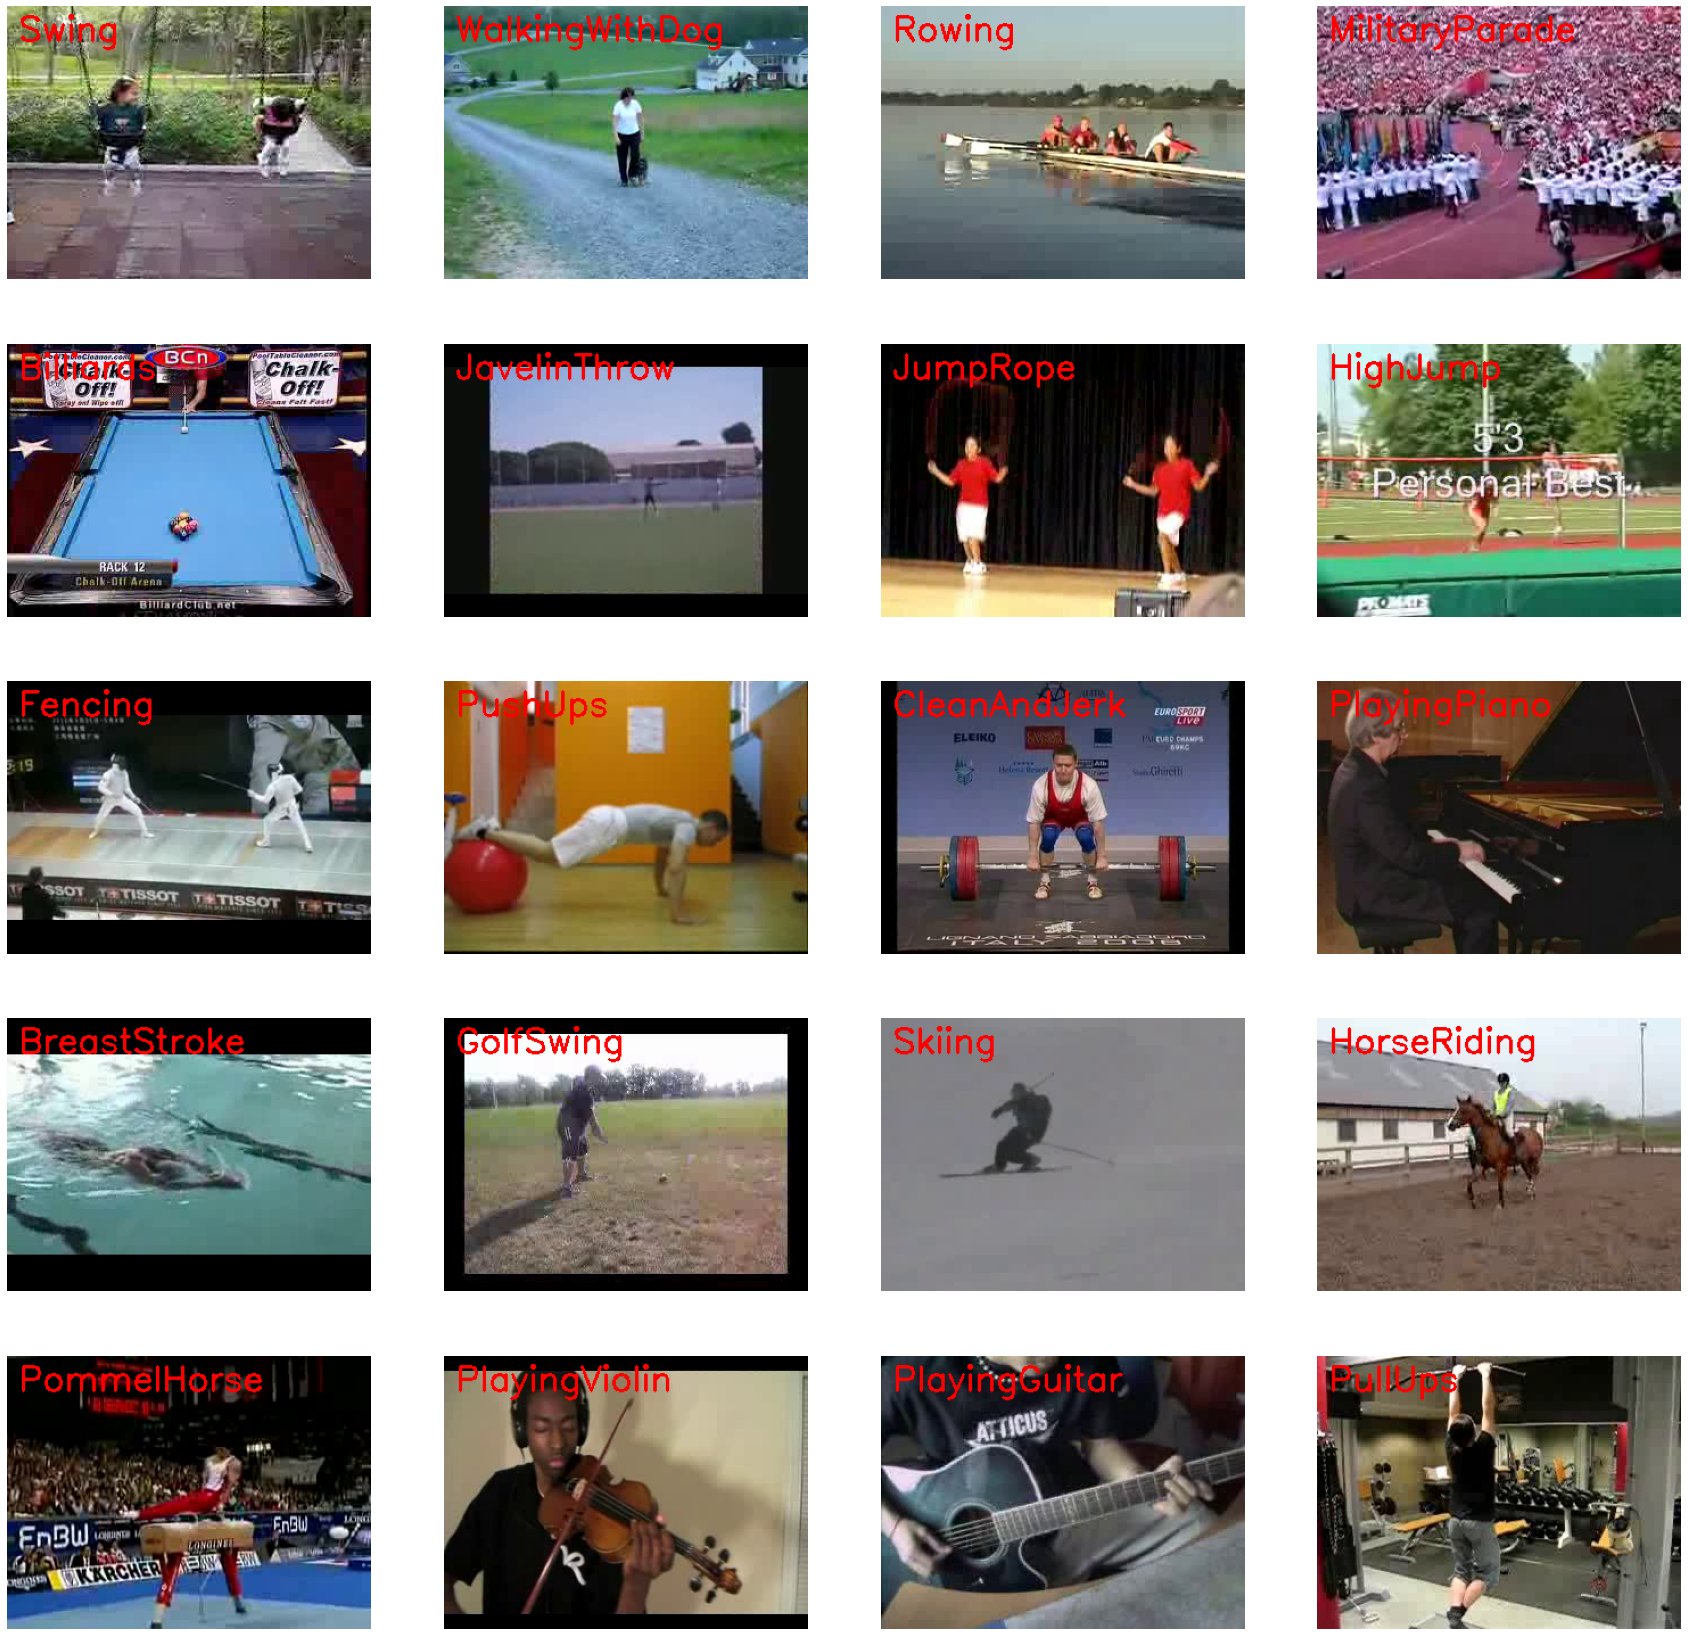

In [6]:
# Create a Matplotlib figure
plt.figure(figsize = (30, 30))
 
# Get Names of all classes in UCF50
all_classes_names = os.listdir('UCF50')
 
# Generate a random sample of images each time the cell runs
random_range = random.sample(range(len(all_classes_names)), 20)
 
# Iterating through all the random samples
for counter, random_index in enumerate(random_range, 1):
 
    # Getting Class Name using Random Index
    selected_class_Name = all_classes_names[random_index]
 
    # Getting a list of all the video files present in a Class Directory
    video_files_names_list = os.listdir(f'UCF50/{selected_class_Name}')
 
    # Randomly selecting a video file
    selected_video_file_name = random.choice(video_files_names_list)
 
    # Reading the Video File Using the Video Capture
    video_reader = cv2.VideoCapture(f'UCF50/{selected_class_Name}/{selected_video_file_name}')
     
    # Reading The First Frame of the Video File
    _, bgr_frame = video_reader.read()
 
    # Closing the VideoCapture object and releasing all resources. 
    video_reader.release()
 
    # Converting the BGR Frame to RGB Frame 
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
 
    # Adding The Class Name Text on top of the Video Frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
     
    # Assigning the Frame to a specific position of a subplot
    plt.subplot(5, 4, counter)
    plt.imshow(rgb_frame)
    plt.axis('off')


In [7]:
image_height, image_width = 64, 64
max_images_per_class = 8000
 
dataset_directory = "UCF50"
classes_list = ["WalkingWithDog", "TaiChi", "Swing", "HorseRace"]
 
model_output_size = len(classes_list)

In [8]:
def frames_extraction(video_path):
    # Empty List declared to store video frames
    frames_list = []
     
    # Reading the Video File Using the VideoCapture
    video_reader = cv2.VideoCapture(video_path)
 
    # Iterating through Video Frames
    while True:
 
        # Reading a frame from the video file 
        success, frame = video_reader.read() 
 
        # If Video frame was not successfully read then break the loop
        if not success:
            break
 
        # Resize the Frame to fixed Dimensions
        resized_frame = cv2.resize(frame, (image_height, image_width))
         
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255
         
        # Appending the normalized frame into the frames list
        frames_list.append(normalized_frame)
     
    # Closing the VideoCapture object and releasing all resources. 
    video_reader.release()
 
    # returning the frames list 
    return frames_list

In [9]:
def create_dataset():
 
    # Declaring Empty Lists to store the features and labels values.
    temp_features = [] 
    features = []
    labels = []
     
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(classes_list):
        print(f'Extracting Data of Class: {class_name}')
         
        # Getting the list of video files present in the specific class name directory
        files_list = os.listdir(os.path.join(dataset_directory, class_name))
 
        # Iterating through all the files present in the files list
        for file_name in files_list:
 
            # Construct the complete video path
            video_file_path = os.path.join(dataset_directory, class_name, file_name)
 
            # Calling the frame_extraction method for every video file path
            frames = frames_extraction(video_file_path)
 
            # Appending the frames to a temporary list.
            temp_features.extend(frames)
         
        # Adding randomly selected frames to the features list
        features.extend(random.sample(temp_features, max_images_per_class))
 
        # Adding Fixed number of labels to the labels list
        labels.extend([class_index] * max_images_per_class)
         
        # Emptying the temp_features list so it can be reused to store all frames of the next class.
        temp_features.clear()
 
    # Converting the features and labels lists to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)  
 
    return features, labels

In [10]:
features, labels = create_dataset()


Extracting Data of Class: WalkingWithDog
Extracting Data of Class: TaiChi
Extracting Data of Class: Swing
Extracting Data of Class: HorseRace


In [11]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)


In [12]:

features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.2, shuffle = True, random_state = seed_constant)


In [13]:
# Let's create a function that will construct our model
def create_model():
 
    # We will use a Sequential model for model construction
    model = Sequential()
 
    # Defining The Model Architecture
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', input_shape = (image_height, image_width, 3)))
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(model_output_size, activation = 'softmax'))
 
    # Printing the models summary
    model.summary()
 
    return model
 
 
# Calling the create_model method
model = create_model()
 
print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 batch_normalization (BatchN  (None, 60, 60, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 64)       0         
 )                                                               
                                                                 
 global_average_pooling2d (G  (None, 64)               0         
 lobalAveragePooling2D)                                          
                                                        

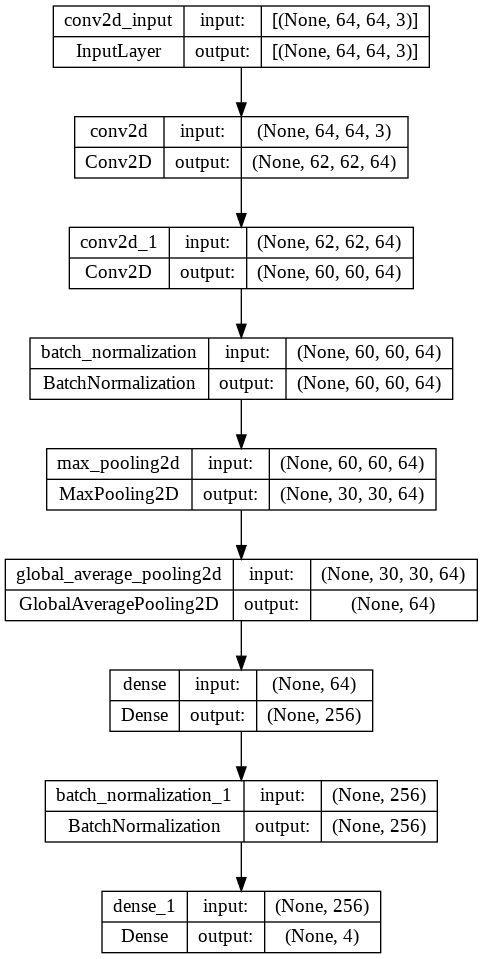

In [14]:
plot_model(model, to_file = 'model_structure_plot.png', show_shapes = True, show_layer_names = True)


In [15]:
# Adding Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
 
# Adding loss, optimizer and metrics values to the model.
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])
 
# Start Training
model_training_history = model.fit(x = features_train, y = labels_train, epochs = 2, batch_size = 4 , shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])


Epoch 1/2
5120/5120 [==============================] - 616s 120ms/step - loss: 0.8574 - accuracy: 0.6589 - val_loss: 0.8672 - val_accuracy: 0.7250
Epoch 2/2
5120/5120 [==============================] - 608s 119ms/step - loss: 0.5255 - accuracy: 0.8052 - val_loss: 0.6208 - val_accuracy: 0.7715


In [16]:
model_evaluation_history = model.evaluate(features_test, labels_test)

200/200 [==============================] - 46s 227ms/step - loss: 0.6577 - accuracy: 0.7611


In [17]:
# Creating a useful name for our model, incase you're saving multiple models (OPTIONAL)
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history
model_name = f'''Model___Date_Time_{current_date_time_string}___Loss_
{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'''
 
# Saving your Model
model.save(model_name)

In [18]:
def download_youtube_videos(youtube_video_url, output_directory):
    # Creating a Video object which includes useful information regarding the youtube video.
    video = pafy.new(youtube_video_url)
 
    # Getting the best available quality object for the youtube video.
    video_best = video.getbest()
 
    # Constructing the Output File Path
    output_file_path = f'{output_directory}/{video.title}.mp4'
 
    # Downloading the youtube video at the best available quality.
    video_best.download(filepath = output_file_path, quiet = True)
 
    # Returning Video Title
    return video.title

In [19]:
def predict_on_live_video(video_file_path, output_file_path, window_size):
 
    # Initialize a Deque Object with a fixed size which will be used to implement moving/rolling average functionality.
    predicted_labels_probabilities_deque = deque(maxlen = window_size)
 
    # Reading the Video File using the VideoCapture Object
    video_reader = cv2.VideoCapture(video_file_path)
 
    # Getting the width and height of the video 
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
 
    # Writing the Overlayed Video Files Using the VideoWriter Object
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'), 24, (original_video_width, original_video_height))
 
    while True: 
 
        # Reading The Frame
        status, frame = video_reader.read() 
 
        if not status:
            break
 
        # Resize the Frame to fixed Dimensions
        resized_frame = cv2.resize(frame, (image_height, image_width))
         
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255
 
        # Passing the Image Normalized Frame to the model and receiving Predicted Probabilities.
        predicted_labels_probabilities = model.predict(np.expand_dims(normalized_frame, axis = 0))[0]
 
        # Appending predicted label probabilities to the deque object
        predicted_labels_probabilities_deque.append(predicted_labels_probabilities)
 
        # Assuring that the Deque is completely filled before starting the averaging process
        if len(predicted_labels_probabilities_deque) == window_size:
 
            # Converting Predicted Labels Probabilities Deque into Numpy array
            predicted_labels_probabilities_np = np.array(predicted_labels_probabilities_deque)
 
            # Calculating Average of Predicted Labels Probabilities Column Wise 
            predicted_labels_probabilities_averaged = predicted_labels_probabilities_np.mean(axis = 0)
 
            # Converting the predicted probabilities into labels by returning the index of the maximum value.
            predicted_label = np.argmax(predicted_labels_probabilities_averaged)
 
            # Accessing The Class Name using predicted label.
            predicted_class_name = classes_list[predicted_label]
           
            # Overlaying Class Name Text Ontop of the Frame
            cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
 
        # Writing The Frame
        video_writer.write(frame)
 
 
        # cv2.imshow('Predicted Frames', frame)
 
        # key_pressed = cv2.waitKey(10)
 
        # if key_pressed == ord('q'):
        #     break
 
    # cv2.destroyAllWindows()
 
     
    # Closing the VideoCapture and VideoWriter objects and releasing all resources held by them. 
    video_reader.release()
    video_writer.release()

In [20]:
pip install youtube-dl==2020.12.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [21]:
# Creating The Output directories if it does not exist
output_directory = 'Youtube_Videos'
os.makedirs(output_directory, exist_ok = True)
 
# Downloading a YouTube Video
video_title = download_youtube_videos('https://www.youtube.com/watch?v=8u0qjmHIOcE', output_directory)
 
# Getting the YouTube Video's path you just downloaded
input_video_file_path = f'{output_directory}/{video_title}.mp4'

In [22]:
# Setting sthe Window Size which will be used by the Rolling Average Proces
window_size = 1
 
# Constructing The Output YouTube Video Path
output_video_file_path = f'{output_directory}/{video_title} -Output-WSize {window_size}.mp4'
 
# Calling the predict_on_live_video method to start the Prediction.
predict_on_live_video(input_video_file_path, output_video_file_path, window_size)
 
# Play Video File in the Notebook
VideoFileClip(output_video_file_path).ipython_display(width = 500)

1/1 [==============================] - 0s 24ms/step


100%|██████████| 866/866 [00:01<00:00, 623.52it/s]
